# Analysis 2.2
- Outcome: Composite UGI cancer in 10 years
- Model: Logistic regression
- Risk score: predicted score from logreg model
- Feature selection: Significant variables based on univariate and multivariate analysis
- Drop patients with missing sex 

## Import libraries

In [1]:
%load_ext rpy2.ipython 
# Load the R magic extension

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.stats import percentileofscore
from helpers.utils import generate_risk_percentile_df, classification_metrics, event_pretty_label, save_to_json

In [26]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [4]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [27]:
%%R
source("utils.R")
library(survival)

In [6]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [7]:
model = 'logreg'
cancer = 'ugica'
ro.globalenv['cancer'] = cancer

analysis_num = '2.2'

In [8]:
%%R 
r_df_normal <- read.csv("df_analysis0_imputed.csv")

In [9]:
%%R
outcome_interval <- "_10yr"
outcome <- ifelse(cancer == "ugica", cancer, paste0("ugica_", cancer)) 
outcome_event <- paste0(tolower(cancer), outcome_interval)

In [10]:
univariate_filename = f'./../results/univariate_analysis_{analysis_num}_{cancer}.csv'
multivariate_filename = f'./../results/multivariate_analysis_{analysis_num}_{cancer}.csv'
risk_results_filename = f'./../results/risk_results_analysis_{analysis_num}_{cancer}.csv'
model_filename = f'{model}_{cancer}.rds'
outcome_event = r['outcome_event'][0]
outcome_interval = r['outcome_interval'][0]

In [11]:
# Pass the DataFrame into the R environment
def pass_df(df, r_df_name):
    ro.globalenv[r_df_name] = df

ro.globalenv['numerical_vars'] = utils.NUMERICAL_VARS
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS 
ro.globalenv['univariate_filename'] = str(univariate_filename)
ro.globalenv['multivariate_filename'] = str(multivariate_filename)
ro.globalenv['model_filename'] = model_filename

## Univariate analysis - logistic regression

### Factorize categorical vars and set reference levels

In [12]:
%%R
# Remove categorical variables that we do not want to do univariate analysis on
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')
r_df_normal$hpylori_active_chronic_binary <- relevel(r_df_normal$hpylori_active_chronic_binary, ref = '0')

In [13]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]
vars_for_univariate

 [1]

 "sex_missing"                   "race_clean"                   
 [3] "ethnicity"                     "alcohol_binary"               
 [5] "tobacco_binary"                "hpylori_active_chronic_binary"
 [7] "hnca"                          "achalasia"                    
 [9] "pud"                           "gerd"                         
[11] "cad"                           "famhx_cancer"                 
[13] "famhx_esophagealca"            "famhx_gastricca"              
[15] "famhx_colonca"                 "famhx_barretts"               
[17] "ASA"                           "PPI"                          
[19] "NSAID"                         "age"                          
[21] "BMI_baseline_all"             


In [14]:
%%R
# HRs, 95% CIs, p-values
results_list <- list()

for (var in vars_for_univariate) {
    # Skip if fewer than 2 levels, ie. 100% in one group
    if (length(unique(na.omit(r_df_normal[[var]]))) < 2) next

    # Build formula
    model <- train_logreg_model(train_set = r_df_normal, selected_vars = var, outcome = outcome_event)

    # Get model summary in formatted dataframe 
    model_df <- get_logreg_univariate_summary(model, var, categorical_vars)
    results_list[[var]] <- model_df
}

final_results <- do.call(rbind, results_list)
write.csv(final_results, univariate_filename)

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to con

In [15]:
# Print the list of significant variables based on univariate analysis
df_univariate = pd.read_csv(univariate_filename)

In [16]:
df_univariate[df_univariate.p_value < 0.05]

,Unnamed: 0,Variable,Level,OR,CI_lower,CI_upper,p_value
0,sex_missing.(Intercept),sex_missing,(Intercept),0.000092,0.000074,0.000113,0.000000e+00
1,sex_missing.sex_missingMALE,sex_missing,MALE,2.785276,2.174709,3.598538,1.417311e-15
2,race_clean.(Intercept),race_clean,(Intercept),0.000203,0.000170,0.000239,0.000000e+00
5,race_clean.race_cleanNo matching concept,race_clean,No matching concept,0.544834,0.412180,0.715920,1.564419e-05
7,ethnicity.(Intercept),ethnicity,(Intercept),0.000228,0.000198,0.000261,0.000000e+00
8,ethnicity.ethnicityHispanic or Latino,ethnicity,Hispanic or Latino,1.399424,1.057743,1.828929,1.596410e-02
9,ethnicity.ethnicityNo matching concept,ethnicity,No matching concept,0.150556,0.094260,0.228258,3.195584e-17
10,alcohol_binary.(Intercept),alcohol_binary,(Intercept),0.000165,0.000145,0.000187,0.000000e+00
12,tobacco_binary.(Intercept),tobacco_binary,(Intercept),0.000134,0.000116,0.000154,0.000000e+00
13,tobacco_binary.tobacco_binary1,tobacco_binary,1,2.362291,1.852674,2.994944,2.143593e-12


## Feature selection

In [17]:
%%R 
selected_vars <- final_results %>%
    filter(Level != "(Intercept)") %>%
    filter(p_value < 0.05) %>%
    distinct(Variable) %>%
    pull(Variable)
selected_vars

selected_vars <- selected_vars[
    !selected_vars %in% cols_to_ignore]
selected_vars

 [1] "sex_missing"     "race_clean"      "ethnicity"       "tobacco_binary" 
 [5] "hnca"            "pud"             "gerd"            "cad"            
 [9] "famhx_cancer"    "famhx_gastricca" "famhx_colonca"   "ASA"            
[13] "PPI"             "NSAID"           "age"            


### Forest plot for univariate visualization

In [18]:
%%R 
forestplot_df <- final_results[(final_results$Variable %in% selected_vars) & (final_results$Level != '(Intercept)'), ]
forestplot_df$Variable_full <- rownames(forestplot_df)

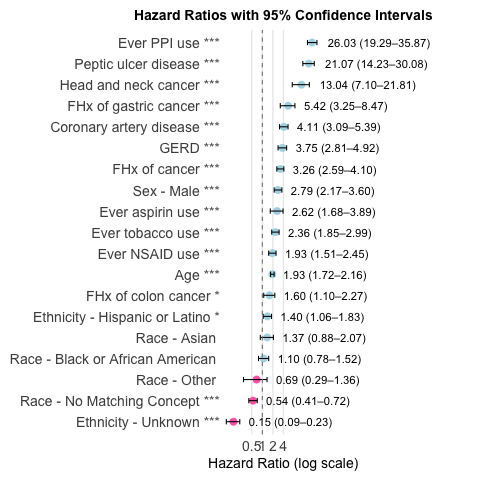

In [19]:
%%R 
plot_univariate_forest(forestplot_df)

## Logistic regression multivariate model training

#### Split dataset into training and validation

In [20]:
%%R 
# Partition data
splits <- partition_data(r_df_normal, selected_vars, outcome_event, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set

# Train model
logreg_model <- train_logreg_model(train_set, selected_vars, outcome_event, model_func=glm)

[1] "Dataset Controls 33890" "Dataset Cases 293"     
[1] "Training Controls 27115" "Training Cases 232"     
[1] "Validation Controls 6775" "Validation Cases 61"     



#### Multivariate analysis

In [21]:
%%R 
# Saves hazard ratio from multivariate analysis into file
multivariate_df <- save_multivariate_logreg_results(logreg_model, multivariate_filename)

Multivariate results saved to ./../results/multivariate_analysis_2.2_ugica.csv 


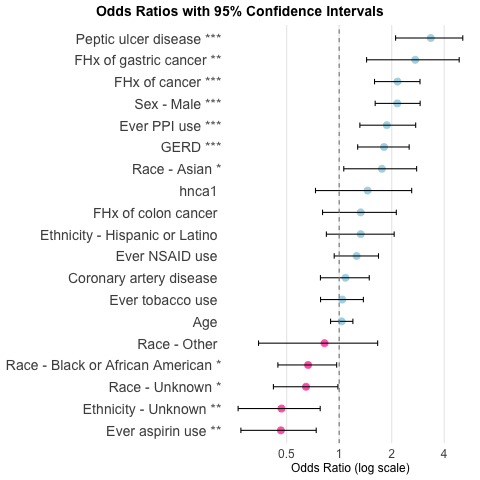

In [22]:
%%R 
plot_multivariate_forest(multivariate_df)

## Results

### Predict events

In [29]:
%%R 
# Get the outcomes in 1 year, 3 year and 5 year horizons
r_df_validation_risk <- generate_event_dataframe(validation_set)
event_5_years <- r_df_validation_risk[[outcome_event]]

# Get the predicted risk 
risk_5_years <- calculate_risk_from_logreg(logreg_model, validation_set)
r_df_validation_risk$pred_risk <- risk_5_years

In [30]:
%%R 
# Convert variable from int to character before transfer to python
r_df_validation_risk[['race']] <- as.character(r_df_validation_risk[['race']])
r_df_validation_risk[['sex']] <- as.character(r_df_validation_risk[['sex']])
r_df_validation_risk[['age_bucket']] <- as.character(r_df_validation_risk[['age_bucket']])
r_df_validation_risk[['visit_year_bucket']] <- as.character(r_df_validation_risk[['visit_year_bucket']])


In [31]:
%%R 
# Set risk threshold to calculate sensitivity and specificity
percentile = 70
cat("\nSensitivity and Metrics at 70% Specificity")
threshold <- quantile(risk_5_years, probs = percentile / 100)
calculate_cm_by_percentile(risk_5_years, event_5_years, threshold)


Sensitivity and Metrics at 70% Specificity

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.764 
Sensitivity: 0.7213115 
Specificity: 0.7037638 
PPV: 0.02145295 
NPV: 0.9964472 
NNS: 55.86536 
     predicted_class
event    0    1
    0 4768 2007
    1   17   44


### Sensitivity and Metrics at threshold that maximizes Youdens

In [32]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = event_5_years, predictor = risk_5_years)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(risk_5_years, event_5_years, optimal_threshold)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.764 
Sensitivity: 0.7213115 
Specificity: 0.7331365 
PPV: 0.0237581 
NPV: 0.9965891 
NNS: 49.14685 
     predicted_class
event    0    1
    0 4967 1808
    1   17   44


### AUROC curves and PR curve

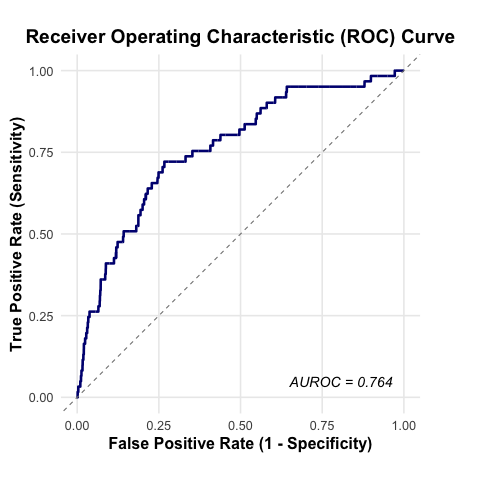

In [33]:
%%R 
# Generate all plots
p1 <- plot_roc_gg(event_5_years, risk_5_years)
p2 <- plot_pr_gg(event_5_years, risk_5_years)
p1

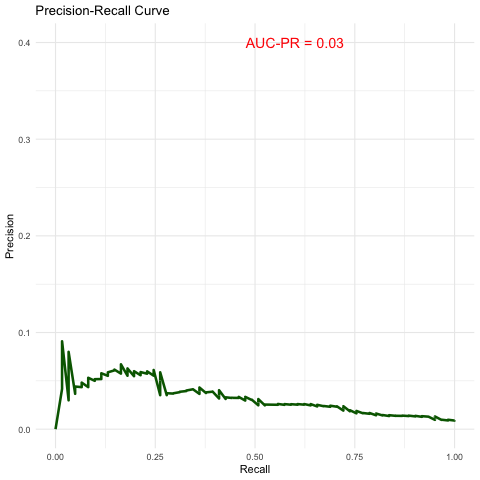

In [34]:
%%R 
p2

### Metrics for each percentile, subdivided by cancer subtype

#### Analysis

In [35]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)
pred_risk = 'pred_risk'
optimal_threshold = r['optimal_threshold'][0]
optimal_threshold_percentile = percentileofscore(df_validation_risk[pred_risk], optimal_threshold, kind='weak')/100.
percentile_cutoffs = [0, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99, 1, optimal_threshold_percentile]

#Create different risk percentiles
df_validation_risk_percentile = generate_risk_percentile_df(df_validation_risk, pred_risk, percentile_cutoffs, optimal_threshold)

In [36]:
df_validation_risk.head()

,time,event_ugica,event_escc,event_eac,event_cgc,event_ncgc,race,sex,age_bucket,visit_year_bucket,ugica_5yr,escc_5yr,eac_5yr,cgc_5yr,ncgc_5yr,ugica_1yr,escc_1yr,eac_1yr,cgc_1yr,ncgc_1yr,ugica_3yr,escc_3yr,eac_3yr,cgc_3yr,ncgc_3yr,ugica_10yr,escc_10yr,eac_10yr,cgc_10yr,ncgc_10yr,pred_risk,actual_percentile,risk_group,risk_p0.5,risk_p0.6,risk_p0.7,risk_p0.7290813341135167,risk_p0.75,risk_p0.8,risk_p0.85,risk_p0.9,risk_p0.95,risk_p0.975,risk_p0.99,risk_p1,high_risk,high_risk_youden
1,59.071869,0,0,0,0,0,No matching concept,MALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004027,0.380925,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.993840,0,0,0,0,0,No matching concept,FEMALE,60-69,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002605,0.198654,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,66.726899,0,0,0,0,0,White,MALE,40-49,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010640,0.783499,0.75,1,1,1,1,1,0,0,0,0,0,0,0,0,1
4,157.043121,0,0,0,0,0,No matching concept,FEMALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002486,0.181246,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.164271,0,0,0,0,0,White,MALE,70-79,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023177,0.940170,0.90,1,1,1,1,1,1,1,1,0,0,0,0,1,1


In [37]:
risk_groups = [f"risk_p{percentile_cutoffs[i+1]}" for i in range(len(percentile_cutoffs) - 1)]
events = [f'ugica{outcome_interval}', f'escc{outcome_interval}', f'eac{outcome_interval}', f'cgc{outcome_interval}', f'ncgc{outcome_interval}']
race_groups = df_validation_risk.race.unique()
age_groups = df_validation_risk.age_bucket.unique()
sex_groups = df_validation_risk.sex.unique()
visit_year_groups = df_validation_risk.visit_year_bucket.unique()

results_dataframe = []

# Get summary statistics for each risk percentile 
for risk_group in risk_groups:
    for event in events: 
        row = classification_metrics(df_validation_risk, risk_group, event)
        results_dataframe.append(row)

# Get summary statistics for each race 
for race in race_groups:
    df_risk_race = df_validation_risk[df_validation_risk.race == race]

    row = classification_metrics(df_risk_race, "high_risk_youden", outcome_event, race)
    results_dataframe.append(row)

# Get summary statistics for each sex 
for sex in sex_groups:
    df_risk_sex = df_validation_risk[df_validation_risk.sex == sex]

    row = classification_metrics(df_risk_sex, "high_risk_youden", outcome_event, sex)
    results_dataframe.append(row)

# Get summary statistics for each age
for age_bucket in age_groups:
    df_risk_age = df_validation_risk[df_validation_risk.age_bucket == age_bucket]

    row = classification_metrics(df_risk_age, "high_risk_youden", outcome_event, age_bucket)
    results_dataframe.append(row)

# Get summary statistics for visit year ranges
for visit_year_bucket in visit_year_groups:
    df_risk_visit_year = df_validation_risk[df_validation_risk.visit_year_bucket == visit_year_bucket]

    row = classification_metrics(df_risk_visit_year, "high_risk_youden", outcome_event, visit_year_bucket)
    results_dataframe.append(row)

df_results = pd.DataFrame(results_dataframe)

/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: RuntimeWarning: invalid value encountered in scalar divide
  prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: Ru

#### Metrics for each percentile and cancer subtype, ordered by percentile

In [38]:
filtered_results = df_results[(df_results['risk_percentile'] == optimal_threshold_percentile)]
filtered_results.tail()

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
55,risk_p0.7290813341135167,0.729081,ugica_10yr,all,6775,61,1852,44 (2.4%),2.4,44,1808,17,4967,0.733031,0.266969,72.131148,73.313653,2.375810,99.658909,49.146849,0.454448
56,risk_p0.7290813341135167,0.729081,escc_10yr,all,6820,16,1852,9 (0.5%),0.5,9,1843,7,4977,0.729374,0.270626,56.250000,72.976540,0.485961,99.859551,289.425812,0.292265
57,risk_p0.7290813341135167,0.729081,eac_10yr,all,6824,12,1852,8 (0.4%),0.4,8,1844,4,4980,0.729666,0.270334,66.666667,72.977726,0.431965,99.919743,284.326269,0.396444
58,risk_p0.7290813341135167,0.729081,cgc_10yr,all,6822,14,1852,11 (0.6%),0.6,11,1841,3,4981,0.730252,0.269748,78.571429,73.013779,0.593952,99.939807,187.350166,0.515852
59,risk_p0.7290813341135167,0.729081,ncgc_10yr,all,6817,19,1852,16 (0.9%),0.9,16,1836,3,4981,0.730983,0.269017,84.210526,73.067332,0.863931,99.939807,124.418612,0.572779


#### Metrics for each percentile and cancer subtype, ordered by cancer subtype

In [39]:
df_results.sort_values(by=['event', 'risk_group'])

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
3,risk_p0.5,0.5,cgc_10yr,all,6822,14,3418,13 (0.4%),0.4,13,3405,1,3417,0.501755,0.498245,92.857143,50.087951,0.380339,99.970743,284.833333,0.429451
8,risk_p0.6,0.6,cgc_10yr,all,6822,14,2732,12 (0.4%),0.4,12,2720,2,4102,0.601814,0.398186,85.714286,60.128994,0.439239,99.951267,256.078202,0.458433
13,risk_p0.7,0.7,cgc_10yr,all,6822,14,2051,11 (0.5%),0.5,11,2040,3,4782,0.701141,0.298859,78.571429,70.096746,0.536324,99.937304,211.136246,0.486682
58,risk_p0.7290813341135167,0.729081,cgc_10yr,all,6822,14,1852,11 (0.6%),0.6,11,1841,3,4981,0.730252,0.269748,78.571429,73.013779,0.593952,99.939807,187.350166,0.515852
18,risk_p0.75,0.75,cgc_10yr,all,6822,14,1709,11 (0.6%),0.6,11,1698,3,5124,0.751170,0.248830,78.571429,75.109938,0.643651,99.941486,170.900000,0.536814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,risk_p0.9,0.9,ugica_10yr,all,6775,61,683,25 (3.7%),3.7,25,658,36,6117,0.898479,0.101521,40.983607,90.287823,3.660322,99.414920,32.517770,0.312714
35,risk_p0.95,0.95,ugica_10yr,all,6775,61,342,16 (4.7%),4.7,16,326,45,6449,0.945728,0.054272,26.229508,95.188192,4.678363,99.307053,25.091488,0.214177
40,risk_p0.975,0.975,ugica_10yr,all,6775,61,171,10 (5.8%),5.8,10,161,51,6614,0.968988,0.031012,16.393443,97.623616,5.847953,99.234809,19.674343,0.140171
45,risk_p0.99,0.99,ugica_10yr,all,6775,61,69,3 (4.3%),4.3,3,66,58,6709,0.981861,0.018139,4.918033,99.025830,4.347826,99.142899,28.647340,0.039439


In [40]:
df_results.to_csv(risk_results_filename)

### Save model, threshold and validation set

In [41]:
%%R 
# Save model
saveRDS(logreg_model, model_filename)

In [42]:
selected_vars = list(r['selected_vars'])  

model_variables = {
    outcome_event: {
        "threshold": optimal_threshold,
        "variables": selected_vars
    }
}

# Save
save_to_json(model_variables, "thresholds.json", key=model)

Saved to thresholds.json
